In [ ]:
# Two issues

# 1) Weird low-frequency artifacts when masking with square masks
# 2) Still missing the fainter points

# To remedy this, I'm going to try to look for bright spots in constrained areas
# Calculate lattice statistics on the new spots found (filtering out some of the spots under stringent criteria)
# But return the indices of all points picked up on the secondpass + firstpass for masking

# I'm also going to restructure find_lattice and the while loop in mask_image...it's a mess.

# Finally, I'm going to code a switch into mask_image to specify whether it's going to look for a lattice at all.

# So let's use this script to develop a new version of mask_image and find_lattice.

In [1]:
import saxtal_functions as sax
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import os
from funcs_mrcio import iwrhdr_opened, irdhdr_opened, iwrsec_opened, irdsec_opened
from itertools import product
plt.rcParams['figure.figsize'] = [10, 10]

In [12]:
import numpy as np
import scipy.fft as sfft
import matplotlib.pyplot as plt
import time
import multiprocessing
import os

In [36]:
# Add/Eliminate parameters from this list as needed

pixel_size = 1.048
threads=16
gaussian_smoothing=15
num_sd=4
x_window_fraction=(0.002, 0.95)
y_window_fraction=(0, 1)
look_for_lattice=True
min_lattice_size=3
epsilon=0.0707
num_sd_secondpass=1.5
box_radius=5
mask_along_lattice=False
replace_angle=45
return_spots=False
return_stats=False
return_fft=False
return_image=False
verbose=True
show_plots=True

filename = 'test_data/test_lattice.mrc'
filename_out = 'test_data/test_lattice_masked.mrc'

scipy_fft(): FFT performed in 145.69 milliseconds.


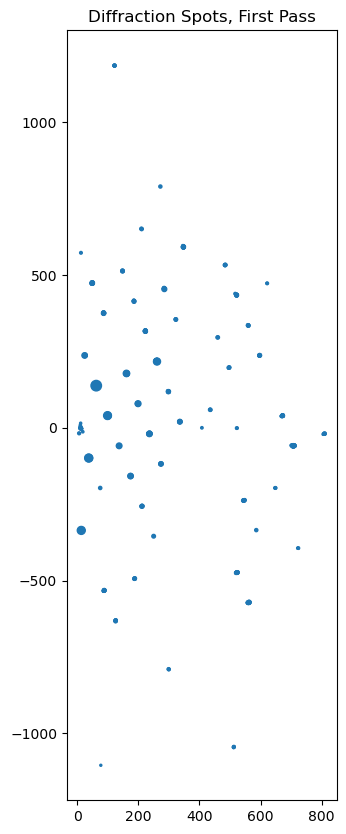

Starting basis: [[138  40]
 [ 62  99]]
Starting basis size: 34289
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 43.806092662170634
[138  62] is larger than [40 99]
The updated basis vectors are [ 98 -37][40 99]
This run resulted in a basis smaller than the last: 22374
The updated basis vectors are: [[-98  40]
 [ 37  99]]
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 91.31661808259379
[40 99] is larger than [-98  37]
The updated basis vectors are [-58 136][-98  37]
This run resulted in a basis larger than the last: 32833
Terminating loop.
------------------------------------


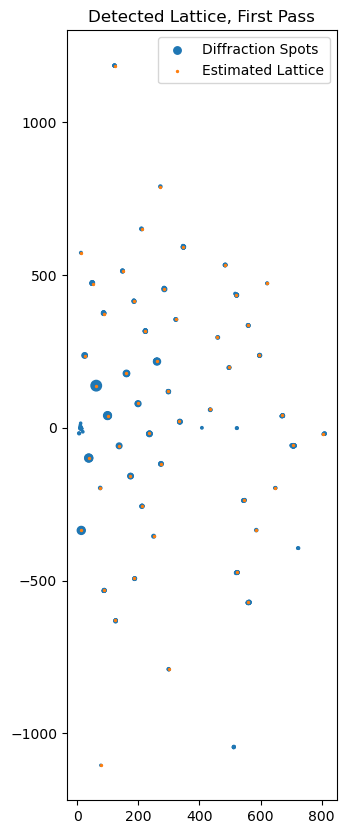

Starting basis: [[-98  40]
 [ 37  99]]
Refined_basis: [[-98.57499915  39.61240811]
 [ 37.3435089   99.26408343]]
Unit cell dimensions (A): 57.27 56.48
Highest resolution spot (A): 5.07


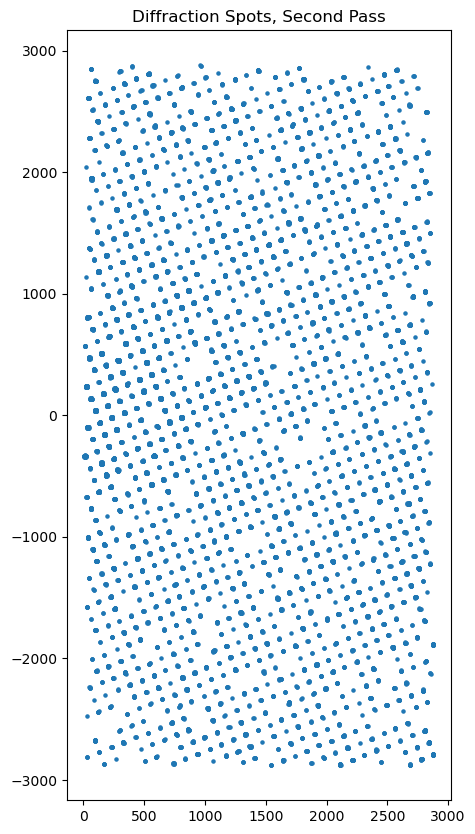

Starting basis: [[-98  40]
 [ 37  99]]
Starting basis size: 22374
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 91.31661808259379
[40 99] is larger than [-98  37]
The updated basis vectors are [-58 136][-98  37]
This run resulted in a basis larger than the last: 32833
Terminating loop.
------------------------------------


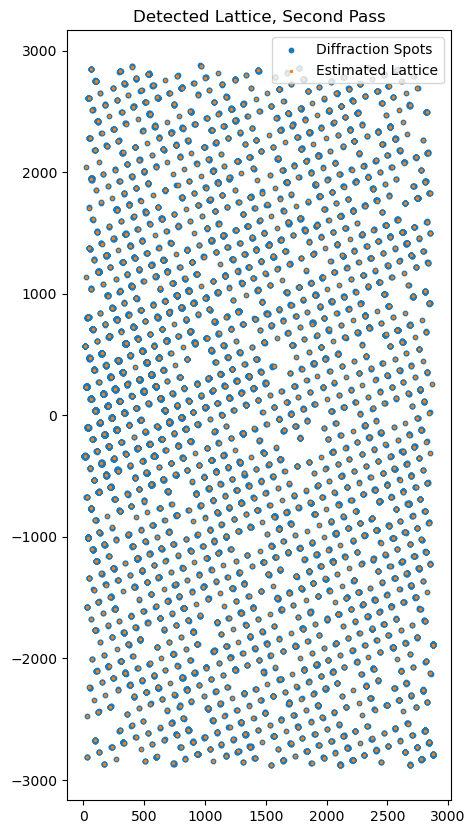

Starting basis: [[-98  40]
 [ 37  99]]
Refined_basis: [[-97.99849496  40.00342099]
 [ 36.99480194  98.99915872]]
Unit cell dimensions (A): 57.63 56.53
Highest resolution spot (A): 1.51
scipy_ifft(): iFFT performed in 111.82 milliseconds.
Export complete!
test_data/test_lattice.mrc masked as test_data/test_lattice_masked.mrc.


In [37]:
sax.mask_image(filename=filename,
               filename_out=filename_out,
               pixel_size=pixel_size,
               threads=threads,
               gaussian_smoothing=gaussian_smoothing,
               num_sd=num_sd,
               x_window_fraction=x_window_fraction,
               y_window_fraction=y_window_fraction,
               look_for_lattice=look_for_lattice,
               min_lattice_size=min_lattice_size,
               epsilon=epsilon,
               num_sd_secondpass=num_sd_secondpass,
               box_radius=box_radius,
               mask_along_lattice=mask_along_lattice,
               replace_angle=replace_angle,
               return_spots=return_spots,
               return_stats=return_stats,
               return_fft=return_fft,
               return_image=return_image,
               verbose=verbose,
               show_plots=show_plots)

In [ ]:
# Mask image

# Import the image
image, header = sax.import_mrc(filename)

# Perform an FFT of the image
padded_fft = sax.scipy_fft(image, verbose, threads)

# Subtract the FFT from a Gaussian-smoothed FFT,
# Smooth again to distribute extremely high intensities to neighbouring points
# But save the original intensities for lattice weighting
log_diff_spectrum, smoothed_spectrum, amplitude_spectrum = sax.generate_diff_spectrum(padded_fft, gaussian_smoothing)

# Find spots that exceed the threshold
indices, amplitudes = sax.find_diffraction_spots_sd(log_diff_spectrum, amplitude_spectrum, num_sd, x_window_fraction, y_window_fraction)